20_50_words
gensim_glove-twitter-50_50_words
150_50_words
gensim_glove-twitter-25_50_words
250_50_words
200_50_words
gensim_glove-twitter-100_50_words
50_50_words


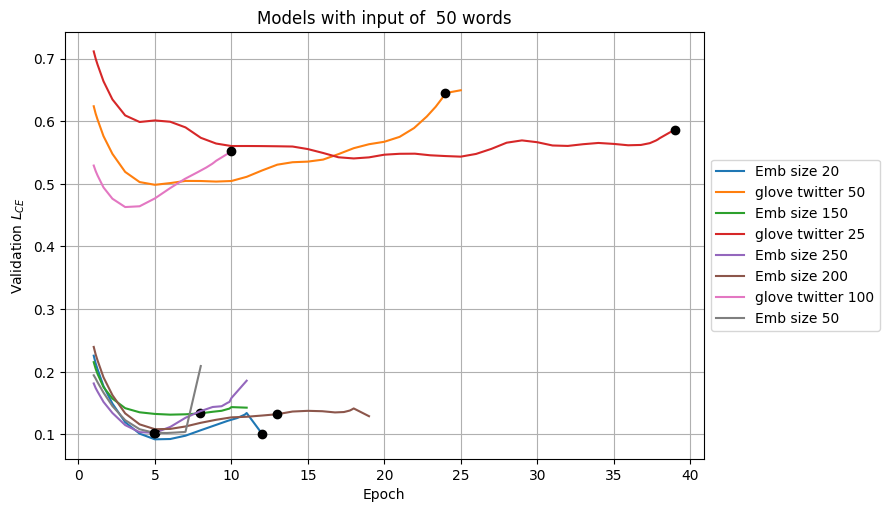

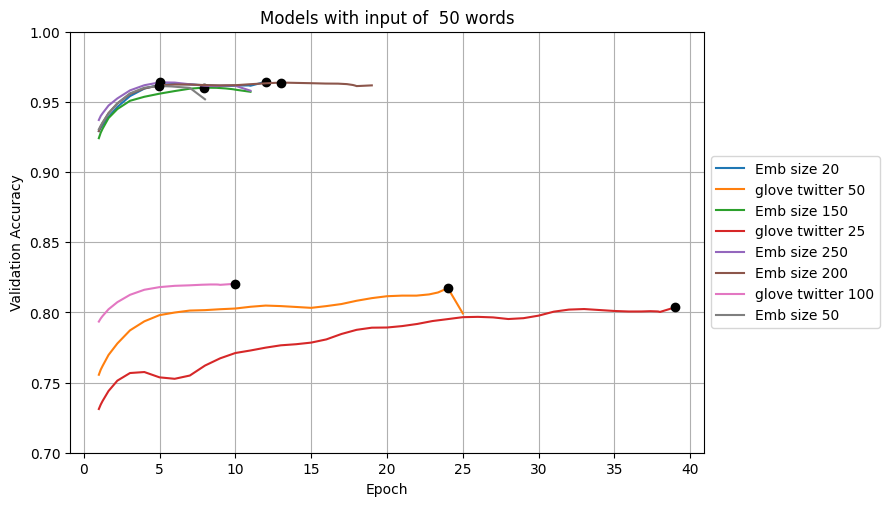

150_100_words
20_100_words
50_100_words
250_100_words
gensim_glove-twitter-50_100_words
200_100_words
gensim_glove-twitter-25_100_words


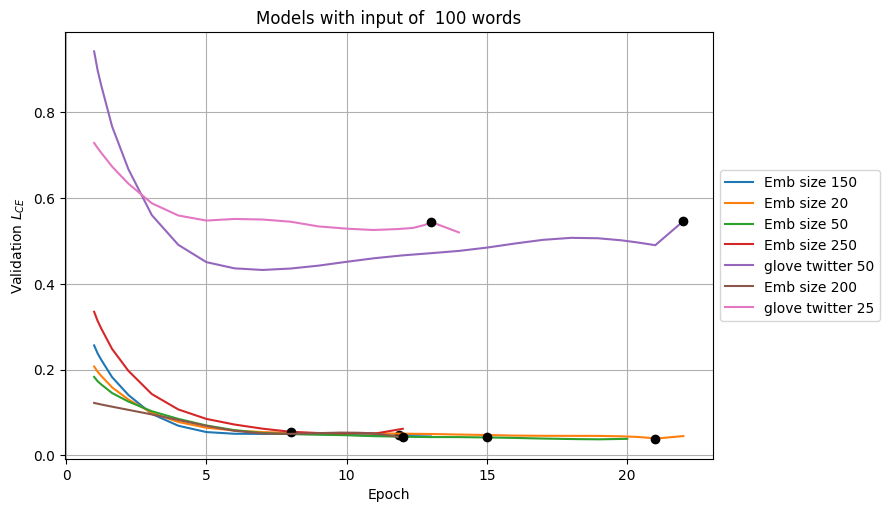

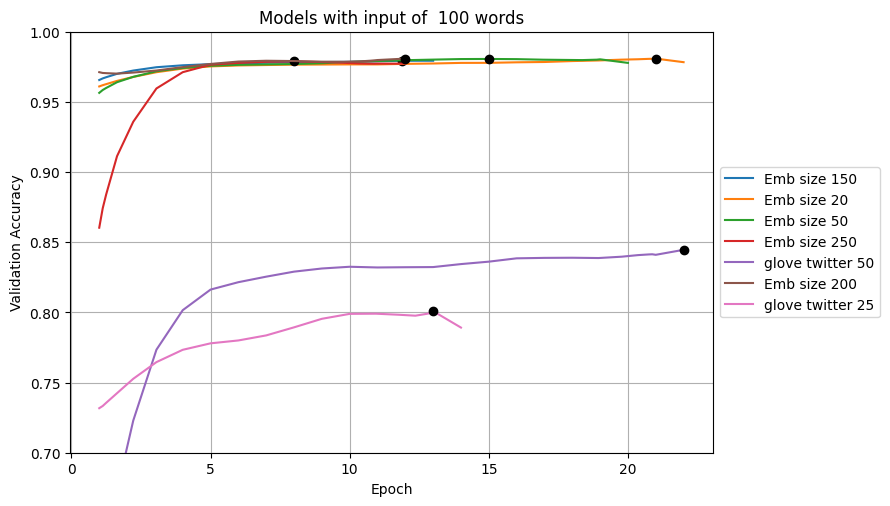

250_150_words
20_150_words
150_150_words
50_150_words
gensim_glove-twitter-50_150_words
gensim_glove-twitter-25_150_words
gensim_glove-twitter-100_150_words
200_150_words


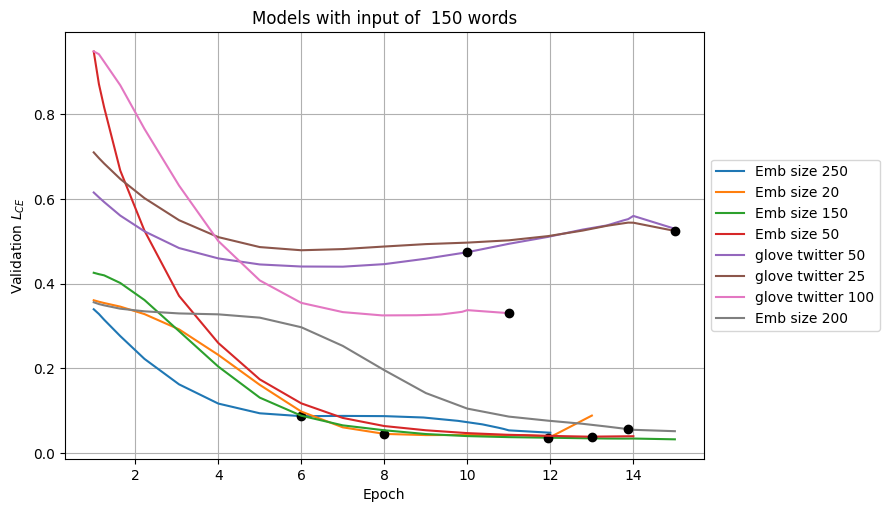

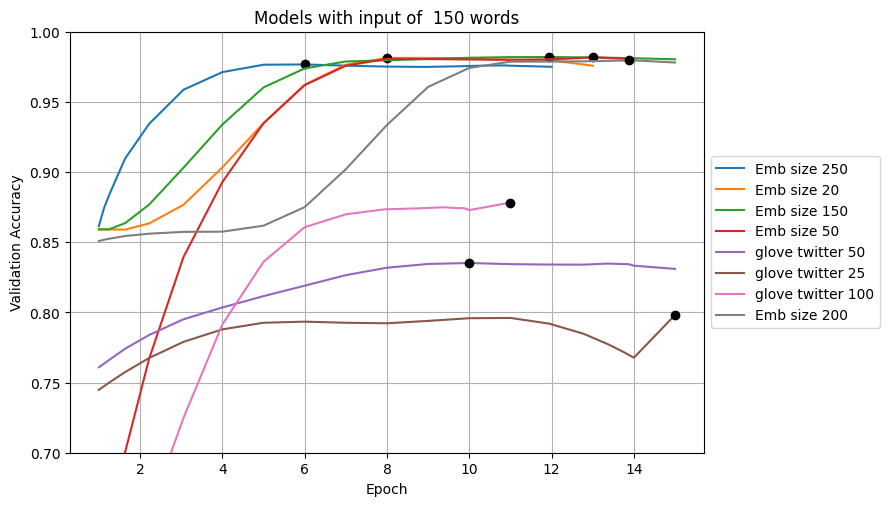

150_200_words
50_200_words
gensim_glove-twitter-25_200_words
200_200_words
gensim_glove-twitter-50_200_words
250_200_words
gensim_glove-twitter-100_200_words
20_200_words


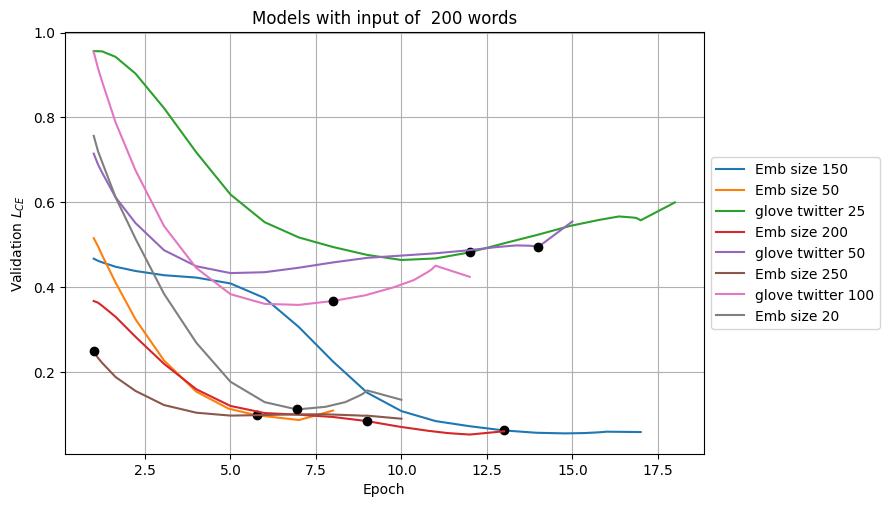

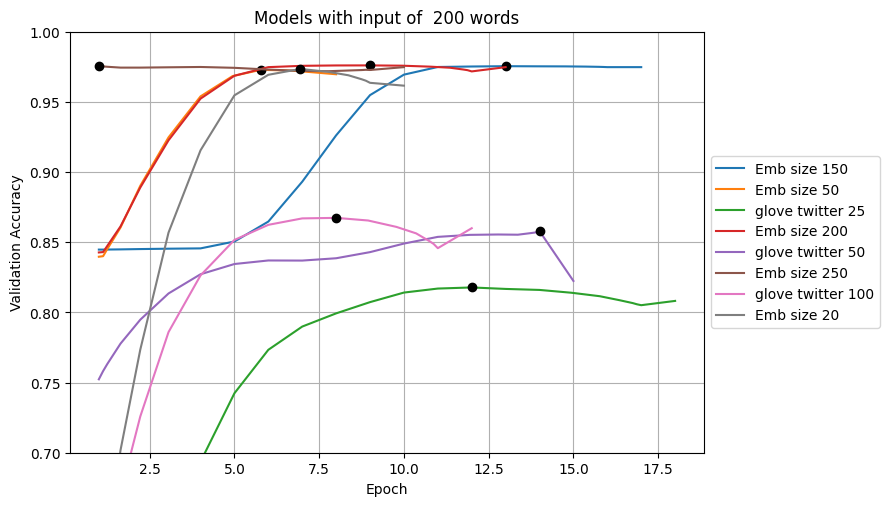

20_250_words
200_250_words
gensim_glove-twitter-50_250_words
150_250_words
gensim_glove-twitter-100_250_words
50_250_words
gensim_glove-twitter-25_250_words
250_250_words


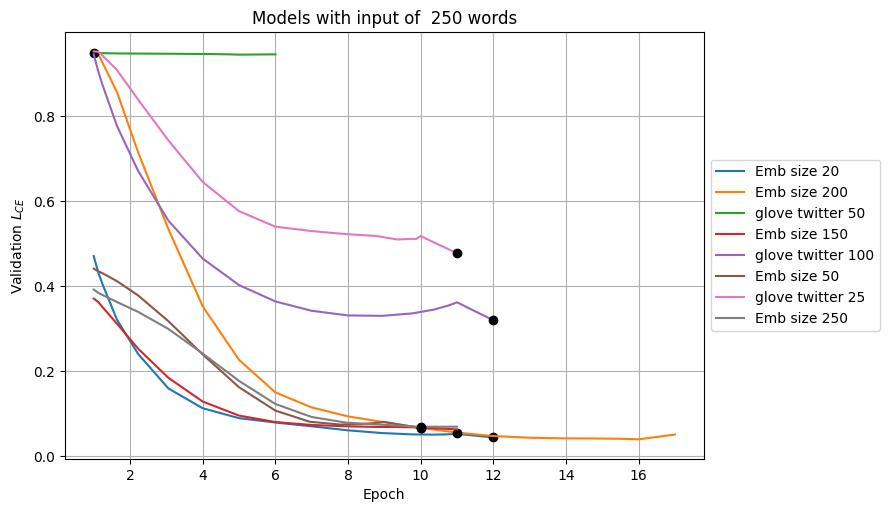

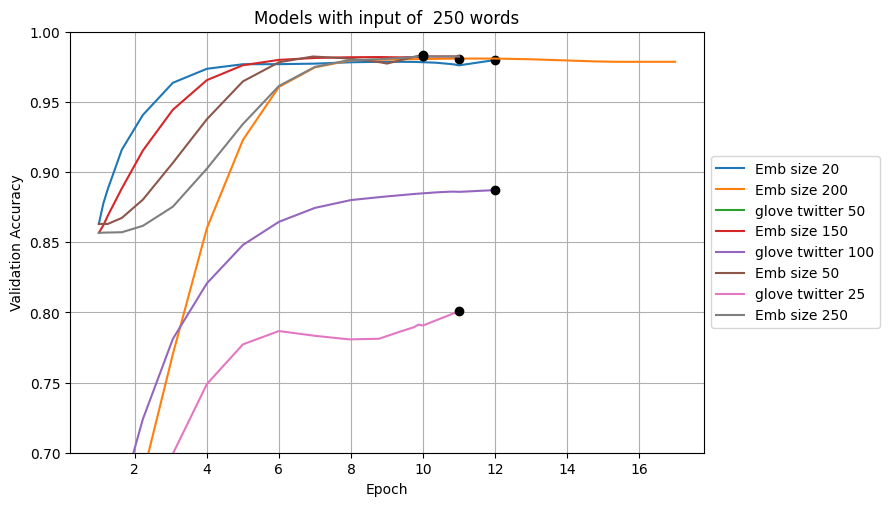

In [10]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


def gaussLinealFilter(x: np.ndarray,
                      y: np.ndarray,
                      n: int = 1,
                      xc: bool = True,
                      yc: bool = True):
    """Apply lineal gaussian filter to X and Y coordinates using convlution. The convolution kernell is the unit (average)

    Args:
        x (np.ndarray): Numpy array with the X data
        y (np.ndarray): Numpy array with the Y data
        n (int, optional): Kernell size (number of points to average). If n=2, the point average is taken with 2 points to the right and 2 points to the left. Defaults to 1.
        xc (bool, optional): To apply filter to X coordinate. Defaults to True.
        yc (bool, optional): To apply filter to Y coordinate. Defaults to True.

    Returns:
        tuple: X and Y filtered arrays (np.ndarray).
    """
    X = [*x[:n]]
    Y = [*y[:n]]
    for i in range(0, len(x)):
        xp = np.average(x[max(i - n, 0):min(i + n + 1, len(x) - 1)])
        yp = np.average(y[max(i - n, 0):min(i + n + 1, len(x) - 1)])
        if not xc:
            xp = x[i]
        if not yc:
            yp = y[i]
        X.append(xp)
        Y.append(yp)
    X += [*x[-n:]]
    Y += [*y[-n:]]
    return np.array(X), np.array(Y)


def gaussMultiLinealFilter(x, y, m=1, n=1, **kargs):
    for i in range(m):
        x, y = gaussLinealFilter(x, y, n, **kargs)
    return x, y


with open("results.csv", "w", encoding="utf-8") as results_file:
    results_file.write(f"model,epoch,accuracy,loss\n")
    for nwords in ["_50_words", "_100_words", "_150_words", "_200_words", "_250_words"]:
        fig1 = plt.figure(figsize=[9, 5])
        ax1 = fig1.add_subplot()
        fig2 = plt.figure(figsize=[9, 5])
        ax2 = fig2.add_subplot()

        logs_folder = "logs_entrega"
        folders = [f"./{logs_folder }/{i}" for i in os.listdir(logs_folder)]
        for folder in folders:
            train_folder = f"{folder}/validation"
            if not os.path.exists(train_folder):
                continue
            files = [
                f"{train_folder}/{i}" for i in os.listdir(train_folder)][0]
            if nwords in files:
                si = summary_iterator(files)
                LOSS = []
                EPOCH = []
                EPOCH2 = []
                ACCURACY = []
                model = files.split("/")[2]
                print(model)
                model = " ".join(files.split("/")[2].split("_")[:-2])
                if not "gensim" in model:
                    model = f"Emb size {model}"
                else:
                    model = model.split(" ")[-1]
                    model = " ".join(model.split("-"))
                    model = f"{model}"

                ktf = 0
                ktf2 = 0
                for l in si:
                    for value in l.summary.value:
                        if "epoch_loss" in value.tag:
                            valor = float(tf.make_ndarray(value.tensor))
                            LOSS.append(valor)
                            ktf += 1
                            EPOCH.append(ktf)
                        if "epoch_accuracy" in value.tag:
                            valor = float(tf.make_ndarray(value.tensor))
                            ACCURACY.append(valor)
                            ktf2 += 1
                            EPOCH2.append(ktf2)
                idx = np.argmax(ACCURACY)
                maxacc = ACCURACY[idx]
                x = EPOCH2[idx]
                loss = LOSS[idx]
                results_file.write(f"{model},{x},{maxacc},{loss}\n")
                EPOCH, LOSS = gaussMultiLinealFilter(EPOCH, LOSS, 3, 1)
                EPOCH2, ACCURACY = gaussMultiLinealFilter(
                    EPOCH2, ACCURACY, 3, 1)
                if len(EPOCH) != 0:
                    maxacc = max(ACCURACY)
                    idx = list(ACCURACY).index(maxacc)
                    x = EPOCH2[idx]
                    xy = [x, LOSS[idx]]
                    ax1.plot(EPOCH, LOSS, label=f"{model}")
                    ax1.plot(*xy, "o", c="k")

                if len(EPOCH2) != 0:
                    maxacc = max(ACCURACY)
                    idx = list(ACCURACY).index(maxacc)
                    x = EPOCH2[idx]
                    xy = [x, maxacc]

                    ax2.plot(EPOCH2, ACCURACY, label=f"{model}")
                    ax2.plot(*xy, "o", c="k")
        # ax1.set_xlim([2.5, 20])
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Validation $L_{CE}$")
        ax1.grid()
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax2.set_xlim([2.5, 20])
        ax2.set_ylim([0.7, 1])
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Validation Accuracy")
        ax2.grid()
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        fig1.tight_layout()
        fig2.tight_layout()
        ax1.set_title(f"Models with input of {' '.join(nwords.split('_'))}")
        ax2.set_title(f"Models with input of {' '.join(nwords.split('_'))}")

        fig1.savefig(f"./figuras/{nwords}_loss.svg")
        fig2.savefig(f"./figuras/{nwords}_acc.svg")

        plt.show()
